__Project Title: Variation in Barometric Variation

__Introduction:__ When a continuous record of groundwater levels is required for an aquifer assessment, wells and nearby surface water stations are typically monitored by automatic datalogging pressure transducers using either piezoelectric crystal or vibrating wire technology. Each generate output voltage that vary with changes in pressure on the sensing unit, including those related to changes in both groundwater levels and atmospheric pressure. Transducer cables that are vented to the atmosphere can be used in certain applications, however it is common for unvented (or ‘absolute’) pressure transducers to be deployed where installation depths are beyond shallow, or tolerances are small.  When using absolute transducers, variation in barometric pressure is subtracted from changes in measured transducer pressure to compensate for the influence of the atmosphere on the raw data. Data are then calibrated to groundwater depth measurements taken from the top of well casing and either reported directly, as feet below land surface, or expressed as an elevation above a common vertical datum like the National Geodetic Vertical Datum of 1929 (NGVD29) or North American Vertical Datum of 1988 (NAVD88). In this study, pressure transducer data from groundwater wells from Nevada was compensated using data from both on-site barometers and off-site weather stations. Output variation in the off-site barometers was assessed by performing regressions on its relationship with changes in distance, elevation, and temperature to the on-site barometers.

__Hypothesis:__ Changes in distance, elevation, and temperature between the sources of barometric and raw groundwater transducer data and groundwater depth below land surface significantly impact the results of barometric groundwater data compensation. Changes in temporal resolution are not significant up to daily intervals.

(**FIGURE 1**) Project Site: Nye County, Nevada. 

Nye County, Nevada has been actively monitored by the USGS and Nevada Water Science Center since underground nuclear testing began in 1941. Groundwater levels can exceed one thousand feet below land surface, creating conditions favorable for deploying absolute transducers and vulnerable to a reliable on-site barometer.

__Datasets:__ Groundwater records from Nye County, Nevada will be obtained from the United States Geological Survey (USGS) National Water Information System (NWIS). NWIS datasets include records of both absolute pressure from unvented pressure transducer and uncorrected barometric pressure expressed in pounds per square inch (psi), compensated groundwater levels that are expressed in feet below land surface and elevations in both NVGD29 and NAVD88 (ft), and groundwater temperature in degrees Celsius. Off-site barometric records were obtained from the National Oceanic and Atmospheric Administration (NOAA) National Centers for Environmental Information (NCEI) Local Climatological Data (LCD) database. Data were obtained from airports in Elko, Reno, Tonopah, and Boulder City, Nevada, and include records of atmospheric pressure in inches of mercury (inHg) and air temperature in degrees celcius.  All datasets provide the date and time for each measurement and station elevation is reported at each data source. 

(**FIGURE 2**) load and provide initial plot of raw data **note that datasets will be combined in the most efficient multi-panel setup possible

LCD airport datasets will be loaded in first, indexed to date/time, and trimmed to useful columns (station pressure and dry bulb temperature)

The pressure and temperature records will be compiled into a single master DataFrame after being resampled to the most coarse data resolution among them (not to exceed 2-hours)

Monitoring Well datasets will be loaded next; I plan to write a function that handles downloaded data, as well as incorperating the script that downloads directly from the website.

DataFrames will be created for each well with the following columns:

    # raw_trans        -    raw pressure transducer
    # baro_onsite      -    on-site baro pressure
    # baro_elko
    # baro_reno
    # baro_tonopah
    # baro_bouldercity
    
The USGS reported water levels below land surface will be loaded and resampled as well.

In [3]:
#%% import python tools and specify parameters

import os
import pandas as pd
import datetime as dt
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

trans_locs = ['trans1', 'trans2', 'trans3', 'trans4', 'trans5', 'trans6']
trans_ids =  ['ER-5-5','WW-C-1','ER-6-1','ER-19-1-3','ER-12-3','UE-20n-1']                
                    # baro locations: figures
baro_locs =  ['BoulderCity','Elko','Reno','Tonopah']

# relevant directories
os.chdir(r'C:\Users\jetry\Documents\ESCI 896 - Hydro Data\PROJECT')
state = ['NH', 'NV']                        # state: subfolders
d_type = ['trans','baro']                   # parameters: subfolders
d_source = ['diver','ll','noaa','usgs']     # data sources: subfolders

In [4]:
#%% load NOAA data: Off-Site Barometers

os.chdir(r'C:\Users\jetry\Documents\ESCI 896 - Hydro Data\PROJECT')
cd = os.getcwd()
dir_data_baro = '\data\\baro-Noaa'
baronames= os.listdir(cd+dir_data_baro)

baro_dfs ={}
for dfn,file in zip(baro_locs, baronames):
    baro_dfs['baro_'+dfn] = pd.read_csv(cd+dir_data_baro+'\\'+file, 
                                        parse_dates=['DATE'], index_col=['DATE'], 
                                        na_values=['-99.9'],usecols=['DATE','HourlyStationPressure','HourlyDryBulbTemperature'],
                                        low_memory=False)

for name in baro_locs:
    baro_dfs['baro_'+name]=baro_dfs['baro_'+name].rename(columns={'HourlyStationPressure':'baro_'+name,
                                                                  'HourlyDryBulbTemperature':'temp_'+name})
    baro_dfs['baro_'+name]['baro_'+name]=pd.to_numeric(baro_dfs['baro_'+name]['baro_'+name], errors='coerce')
    baro_dfs['baro_'+name]['temp_'+name]=pd.to_numeric(baro_dfs['baro_'+name]['temp_'+name], errors='coerce')
    baro_dfs['baro_'+name]['baro_'+name]=baro_dfs['baro_'+name]['baro_'+name]*0.49115415222661
    baro_dfs['baro_'+name]=baro_dfs['baro_'+name].interpolate(method='linear')
    baro_dfs['baro_'+name]=baro_dfs['baro_'+name].resample('H').mean()

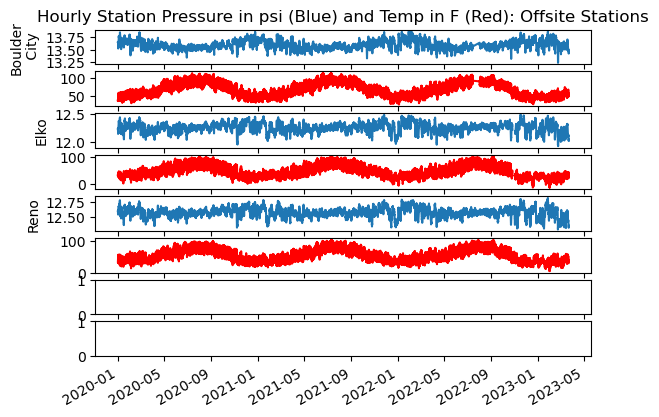

In [6]:
#%% plot NOAA data: Off-Site Barometers

# server is down but I will address the Tonopah data

fig1,(ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)=plt.subplots(nrows=8,ncols=1,sharex=True)
ax1.plot(baro_dfs['baro_BoulderCity']['baro_BoulderCity'])
ax2.plot(baro_dfs['baro_BoulderCity']['temp_BoulderCity'],'r-')
ax3.plot(baro_dfs['baro_Elko']['baro_Elko'])
ax4.plot(baro_dfs['baro_Elko']['temp_Elko'],'r-')
ax5.plot(baro_dfs['baro_Reno']['baro_Reno'])
ax6.plot(baro_dfs['baro_Reno']['temp_Reno'],'r-')
ax1.set_ylabel('Boulder\n City')
ax3.set_ylabel('Elko')
ax5.set_ylabel('Reno')
ax1.set_title('Hourly Station Pressure in psi (Blue) and Temp in F (Red): Offsite Stations')
plt.gcf().autofmt_xdate()

In [7]:
#%% load USGS data

dir_data_trans = '\data\\trans-Usgs'
dir_data_ontrans = '\data\\baro-Usgs'
dir_data_ontemp = '\data\\temp-Usgs'
dir_data_wl = '\data\\wl-Usgs'

transnames= os.listdir(cd+dir_data_trans)
ontransnames= os.listdir(cd+dir_data_ontrans)
ontempnames= os.listdir(cd+dir_data_ontemp)
wlnames= os.listdir(cd+dir_data_wl)

trans_dfs ={}
wl_dfs={}

for dfn,file in zip(trans_locs, transnames):
    trans_dfs[dfn] = pd.read_csv(cd+dir_data_trans+'\\'+file, sep='\t', parse_dates=['20d'], index_col=['20d'], na_values=['-99.9'], comment ='#', header=1, usecols=['20d','14n'])

for name in trans_locs:
    trans_dfs[name]=trans_dfs[name].rename(columns={'14n':'p_abs'})    

for name,file in zip(trans_locs, ontransnames):
    trans_dfs[name]['onbaro'] = pd.read_csv(cd+dir_data_ontrans+'\\'+file, sep='\t', 
                                            na_values=['-99.9'], parse_dates=['20d'], 
                                            index_col=['20d'],comment ='#', header=1, usecols=['20d','14n'])

for name,file in zip(trans_locs, ontempnames):
    trans_dfs[name]['ontemp'] = pd.read_csv(cd+dir_data_ontemp+'\\'+file, sep='\t', na_values=['-99.9'],
                                            parse_dates=['20d'], index_col=['20d'],
                                            comment ='#', header=1, usecols=['20d','14n'])

for name,file in zip(trans_locs, wlnames):
    wl_dfs[name] = pd.read_csv(cd+dir_data_wl+'\\'+file, sep='\t', 
                               na_values=['-99.9'], comment ='#', header=1, 
                               usecols=['20d','14n'],parse_dates=['20d'], index_col=['20d'])\

for name in trans_locs:
    wl_dfs[name]=wl_dfs[name].rename(columns={'14n':'usgs_wlbl'})
    wl_dfs[name]=wl_dfs[name].resample('H').mean()
    
    #slice data
for name in trans_locs:
    trans_dfs[name]=trans_dfs[name].resample('H').mean()
    trans_dfs[name]['baro_bc']=baro_dfs['baro_BoulderCity']['baro_BoulderCity'][trans_dfs[name].index[0]:trans_dfs[name].index[-1]]
    trans_dfs[name]['baro_elko']=baro_dfs['baro_Elko']['baro_Elko'][trans_dfs[name].index[0]:trans_dfs[name].index[-1]]
    trans_dfs[name]['baro_reno']=baro_dfs['baro_Reno']['baro_Reno'][trans_dfs[name].index[0]:trans_dfs[name].index[-1]]
    trans_dfs[name]=trans_dfs[name].interpolate(method='linear')
    
    #barometric compensation
    trans_dfs[name]['comp_on']=wl_dfs[name].usgs_wlbl[0] + ((trans_dfs[name].loc[trans_dfs[name].index[0],'p_abs']-trans_dfs[name]['p_abs'])*2.31) - ((trans_dfs[name].loc[trans_dfs[name].index[0],'onbaro']-trans_dfs[name]['onbaro'])*2.31)
    trans_dfs[name]['comp_bc']=wl_dfs[name].usgs_wlbl[0] + ((trans_dfs[name].loc[trans_dfs[name].index[0],'p_abs']-trans_dfs[name]['p_abs'])*2.31) - ((trans_dfs[name].loc[trans_dfs[name].index[0],'baro_bc']-trans_dfs[name]['baro_bc'])*2.31)
    trans_dfs[name]['comp_elko']=wl_dfs[name].usgs_wlbl[0] + ((trans_dfs[name].loc[trans_dfs[name].index[0],'p_abs']-trans_dfs[name]['p_abs'])*2.31) - ((trans_dfs[name].loc[trans_dfs[name].index[0],'baro_elko']-trans_dfs[name]['baro_elko'])*2.31)
    trans_dfs[name]['comp_reno']=wl_dfs[name].usgs_wlbl[0] + ((trans_dfs[name].loc[trans_dfs[name].index[0],'p_abs']-trans_dfs[name]['p_abs'])*2.31) - ((trans_dfs[name].loc[trans_dfs[name].index[0],'baro_reno']-trans_dfs[name]['baro_reno'])*2.31)
    
    #calc output differences
    trans_dfs[name]['diff_bc']=trans_dfs[name]['comp_bc']-trans_dfs[name]['comp_on']
    trans_dfs[name]['diff_elko']=trans_dfs[name]['comp_elko']-trans_dfs[name]['comp_on']
    trans_dfs[name]['diff_reno']=trans_dfs[name]['comp_reno']-trans_dfs[name]['comp_on']

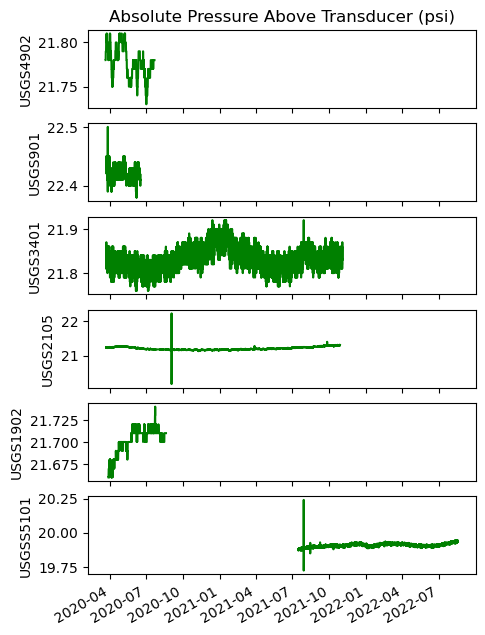

In [5]:
#%% plot USGS data: raw transducer pressure

fig2,(ax11,ax22,ax33,ax44,ax55,ax66)=plt.subplots(nrows=6,ncols=1,sharex=True,figsize = (5,8))
ax11.plot(trans1['14n'],'g-')
ax22.plot(trans2['14n'],'g-')
ax33.plot(trans3['14n'],'g-')
ax44.plot(trans4['14n'],'g-')
ax55.plot(trans5['14n'],'g-')
ax66.plot(trans6['14n'],'g-')
ax11.set_ylabel('USGS4902')
ax22.set_ylabel('USGS901')
ax33.set_ylabel('USGS3401')
ax44.set_ylabel('USGS2105')
ax55.set_ylabel('USGS1902')
ax66.set_ylabel('USGSS5101')
ax11.set_title('Absolute Pressure Above Transducer (psi)')
plt.gcf().autofmt_xdate()

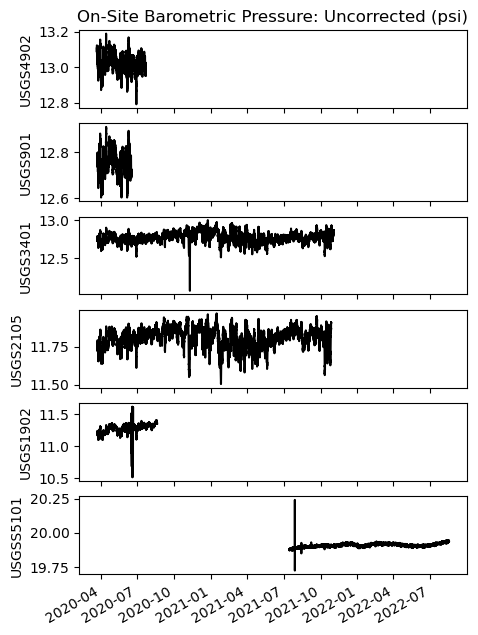

In [7]:
#%% plot USGS data: on-site barometers
fig3,(ax111,ax222,ax333,ax444,ax555,ax666)=plt.subplots(nrows=6,ncols=1,sharex=True,figsize = (5,8))
ax111.plot(ontrans1['14n'],'k-')
ax222.plot(ontrans2['14n'],'k-')
ax333.plot(ontrans3['14n'],'k-')
ax444.plot(ontrans4['14n'],'k-')
ax555.plot(ontrans5['14n'],'k-')
ax666.plot(trans6['14n'],'k-')
ax111.set_ylabel('USGS4902')
ax222.set_ylabel('USGS901')
ax333.set_ylabel('USGS3401')
ax444.set_ylabel('USGS2105')
ax555.set_ylabel('USGS1902')
ax666.set_ylabel('USGSS5101')
ax111.set_title('On-Site Barometric Pressure: Uncorrected (psi)')
plt.gcf().autofmt_xdate()


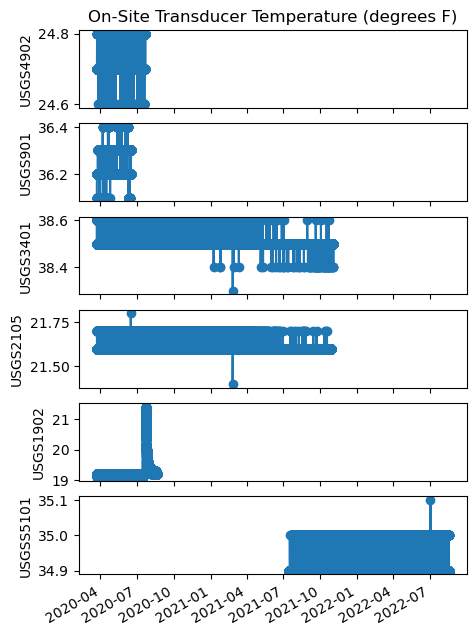

In [9]:
#%% plot USGS data: on-site temperature
fig4,(ax1111,ax2222,ax3333,ax4444,ax5555,ax6666)=plt.subplots(nrows=6,ncols=1,sharex=True,figsize = (5,8))
ax1111.plot(ontemp1['14n'],'o-')
ax2222.plot(ontemp2['14n'],'o-')
ax3333.plot(ontemp3['14n'],'o-')
ax4444.plot(ontemp4['14n'],'o-')
ax5555.plot(ontemp5['14n'],'o-')
ax6666.plot(ontemp6['14n'],'o-')
ax1111.set_ylabel('USGS4902')
ax2222.set_ylabel('USGS901')
ax3333.set_ylabel('USGS3401')
ax4444.set_ylabel('USGS2105')
ax5555.set_ylabel('USGS1902')
ax6666.set_ylabel('USGSS5101')
ax1111.set_title('On-Site Transducer Temperature (degrees F)')
plt.gcf().autofmt_xdate()

DRAFT RESULTS SECTION - 

LOCATION 4 (USGS:371043116142105) was selected and used to demonstrate the method by depicting the relationship between distance and compensation output. Note that the final version will include data from 6 locations and their relative distances to 4 different airports.

Barometric Compensation - 

This next section compensates raw data for barometric variation and calibrates the output to the first reported water level by USGS. This parameter can also be a hand level taken in the field at the time of transducer installation. The raw data are converted from psi to ft of water and the final output are time-series of groundwater levels below land surface.

DRAFT FIGURE 3 - CODE NEEDS UPDATING 

The next section of code generates a stacked plot depicting the same transducer data compensated with 4 different barometers; the on-site barometer, Boulder City Airport, Elko Airport, and Reno Airport. The USGS reported water levels below land surface are presented above the on-site compensation to demonstrate the effectiveness of the formula (output matches USGS reporting)

In [ ]:
# DRAFT figure 3

fig6,(ax61,ax62,ax63,ax64,ax65,ax66)=plt.subplots(nrows=6,ncols=1,sharex=True,figsize = (8,10))
ax61.set_title('Results of Compensation at USGS: 371043116142105\nWater Levels reported as Feet Below Land Surface')
ax61.plot(trans4.index,trans4.wlbl_usgs,'k-')
ax61.set_ylim(1000.5,1002.5)
ax62.plot(trans4.index,trans4_on,'r-')
ax62.set_ylim(1000.5,1002.5)
ax63.plot(trans4.index,trans4_bc,'c-')
ax63.set_ylim(1000.5,1002.5)
ax64.plot(trans4.index,trans4_e,'g-')
ax64.set_ylim(1000.5,1002.5)
ax65.plot(trans4.index,trans4_r,'y-')
ax65.set_ylim(1000.5,1002.5)
ax66.set_ylim(1000.5,1002.5)
ax61.set_ylabel('USGS\nreported')
ax62.set_ylabel('On-Site Baro\n(formula check)')
ax63.set_ylabel('Boulder City\nBarometer')
ax64.set_ylabel('Elko\nBarometer')
ax65.set_ylabel('Reno\nBarometer')
ax66.set_ylabel('Airport 4 (TBD)\nBarometer')
plt.gcf().autofmt_xdate()

EXAMPLE CODE BELOW - OLD VARIABLE NAMES: WILL NOT WORK - UPDATING WRANGLING PROTOCOL TO INCLUDE ALL 6 LOCATIONS IN DATAFRAME DICTIONARIES

The next section of code calculates the difference in compensation results between the on-site barometer and each of the three off-site airports. The distance between the selected location and each of the airports is added in a column next to the observed water level difference between compensation results. The data are re0indexed to the water level difference and then concatenated into master DataFrame ('trans4data').

In [3]:
#%% draft results -next

#map distances calculated using on-line coordinate tool in meters and converted to feet
trans4dist_bouldercity_ft = 184129*3.2808399  
trans4dist_elko_ft=407308.59*3.2808399
trans4dist_reno_ft = 402173.69*3.2808399

# water level differences are calculates
trans4_diff_bc = trans4_bc-trans4_on
trans4_diff_e = trans4_e-trans4_on
trans4_diff_r = trans4_r-trans4_on

# arrays with distance values are created
trans4_dist_bc =np.ones_like(trans4_diff_bc)
trans4_dist_bc=trans4_dist_bc*trans4dist_bouldercity_ft

trans4_dist_e = np.ones_like(trans4_diff_e)
trans4_dist_e = trans4_dist_bc*trans4dist_elko_ft

trans4_dist_r = np.ones_like(trans4_diff_r)
trans4_dist_r = trans4_dist_bc*trans4dist_reno_ft

# DataFrames are created and indexed to water level difference
trans4data=pd.DataFrame(data=trans4_diff_bc)
trans4data['distance']=trans4_dist_bc
trans4data=trans4data.reset_index()
trans4data=trans4data.rename(columns={0:'wl_diff'})
trans4data=trans4data.set_index('wl_diff')
trans4data=trans4data.drop(labels='index',axis=1)

trans4data_e=pd.DataFrame(data=trans4_diff_e)
trans4data_e['distance']=trans4_dist_e
trans4data_e=trans4data_e.reset_index()
trans4data_e=trans4data_e.rename(columns={0:'wl_diff'})
trans4data_e=trans4data_e.set_index('wl_diff')
trans4data_e=trans4data_e.drop(labels='index',axis=1)

trans4data_r=pd.DataFrame(data=trans4_diff_r)
trans4data_r['distance']=trans4_dist_r
trans4data_r=trans4data_r.reset_index()
trans4data_r=trans4data_r.rename(columns={0:'wl_diff'})
trans4data_r=trans4data_r.set_index('wl_diff')
trans4data_r=trans4data_r.drop(labels='index',axis=1)

# create master DataFrame for loc 4
trans4data=trans4data.append(trans4data_e,ignore_index=False)
trans4data=trans4data.append(trans4data_r,ignore_index=False)

DRAFT FIGURE 4 - NEEDS NEW VARIABLE UPDATES and LOOPS etc

The next set of code creates a scatter plot of barometric compensation difference versus distance to barometer and also plots a linear regression.

In [ ]:
# DRAFT results figure 4

def regplot(att,label,title):
    """ Plot least-squares fit to data.

    Function to create scatter plot of x-y data, including regression
    line(s) and annotation with regression parameters and statistics.

    Parameters
    ----------
    att : array or series
        Name of target numerical attribute in annual SCAN dataset
        
    label : string
        Text to use as y-label on plot
        
    title : string
        Text to use as title on plot
    """
    # define regression function variables
    x=trans4data.index.values                                # index numbers for regression
    lsq_coeff = stats.linregress(x, trans4data[att])         # least squares coefficients
    
    # create plot of attribute with least squares and thiel-sen regressions
    fig, ax = plt.subplots()
    ax.plot(x, trans4data[att], 'k.')
    ax.plot(x, lsq_coeff.intercept + lsq_coeff.slope * x, 'b-', label='Linear regression')
    
    # annotate plot with regression slopes and correlation coefficients 
    xx = ax.get_xlim()
    yy = ax.get_ylim()    
    ax.annotate(f'Least-squares slope = {lsq_coeff.slope:.1f} +/- {2*lsq_coeff.stderr:.1f}',
                xy=(xx[1]-0.025*(xx[1]-xx[0]), yy[0] + 0.03*(yy[1]-yy[0])),
                horizontalalignment='right')
    ax.annotate(f'Least-squares correlation = {lsq_coeff.rvalue:.1f}; p = {lsq_coeff.pvalue:.6f}',
                xy=(xx[1]-0.025*(xx[1]-xx[0]), yy[0] + 0.08*(yy[1]-yy[0])),
                horizontalalignment='right')

    
    # set plot formatting and show plot
    ax.set_xlabel('Difference in Barometric Compensation Output (ft)')
    ax.set_ylabel(label)
    ax.legend(loc='upper left')
    ax.set_title(title)
    plt.show()

# create DRAFT figure 4

fig7=regplot(trans4data.columns[0],'distance','Scatter Plot of Distance versus Compensation Difference')

The rest of the cells describe my goals for final results. I hope to create a master table indexed to difference in compensation output, containing data appended from each of the 6 locations. There will be columns for distance to barometer, difference in elevation, difference in temperature between the transducer and surface at each barometer.

While executing the draft results section I have realized that some of the nuance in how data are wrangled may be adjusted to increase processing efficiency.


Final version of figure 4 will be created from a master DatFrame with the following columns indexed to time,
and will be a stacked set of scatter plots of wl_diff vs the rest of the parameters (with regressions)

    # wl_diff
    # dist
    # elev
    # temp_diff
    # wlbl_onsite
    # raw_trans

I will then use the time index to trim data to each of the four seasons and create FIGURE 5 with the same stacked plots, but now 4 columns of them (one per season) to identify any seasonal trends.

FIGURE 6 will be a stacked set of hydrographs for the 6 locations. I will format the on-site calibration to be distinct, and present it along with the other barometers for each location.

Discussion: The discussion section will focus on the questions below. In practice, the results will provide the opportunity for increasing the accuracy with which groundwater levels recorded in an observation well can represent aquifer groundwater levels proximal to the well, in situations where on-site barometric data is unavailable.
    
    Do any of the target parameters show a statistically significant impact on the output when using off-site air presure data for barometric compensation?
    
    Is there any seasonal variation to these impacts?
    
    Are the raw barometric records correlated to the on-site barometer?
    
    How do variations in compensation output compare with magnitudes of natural water level fluctuation in the wells?
    
    As a groundwater professional, how could you use these results and interpretations to overcome project challenges such as damaged/failed equipment or budget limitations?